# GPT from scratch (but very very small)
In this notebook we will build a GPT-style transformer from scratch. Heavily based on [nanoGPT](https://github.com/karpathy/nanoGPT) and [minGPT](https://github.com/karpathy/minGPT/tree/master) by Andrej Karpathy. 

Emphasis on readable code, minimal and simple implementations, and (relatively) fast training.

In [ ]:
from dataclasses import dataclass
import math
from typing import Tuple
from matplotlib import pyplot as plt
from tqdm.auto import tqdm, trange

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import RandomSampler

DEVICE = torch.device('mps') # 'mps' for ARM macbooks, 'cuda' for colab, 'cpu' otherwise

## Data
We use the tiny shakespeare dataset to train a character level transformer to predict text that looks like shakespeare. All data is in one text file, which we download below.

In [3]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2024-02-13 11:34:37--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1,1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1,06M  --.-KB/s    in 0,08s   

2024-02-13 11:34:37 (13,0 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [4]:
class CharacterDataset:
    """
    Helper class that can:
        - read a text file
        - encode characters to integers
        - decode integers to characters
        - split in train and test
        - be used by a torch dataloader later (this is why we require a 'block size')
    """
    def __init__(self, data: str, block_size: int=256):
        self.chars = sorted(list(set(data)))
        self.encode = { ch:i for i,ch in enumerate(self.chars) }
        self.decode = { i:ch for i,ch in enumerate(self.chars) }
        self.data = data
        self.vocab_size = len(self.chars)
        self.block_size = block_size

    @classmethod
    def from_textfile(cls, filename: str, block_size: int=256) -> 'CharacterDataset':
        with open(filename, 'r') as fh:
            return cls(data=fh.read(), block_size=block_size)

    def train_test_split(self, train_percentage: float=0.8) -> Tuple['CharacterDataset','CharacterDataset']:
        n_train_chars = int(train_percentage * len(self.data))

        train_data = self.data[:n_train_chars]
        train_dataset = CharacterDataset(train_data, self.block_size)
        train_dataset.encode = self.encode
        train_dataset.decode = self.decode

        test_data = self.data[n_train_chars:]
        test_dataset = CharacterDataset(test_data, self.block_size)
        test_dataset.encode = self.encode
        test_dataset.decode = self.decode

        return train_dataset, test_dataset

    def __len__(self) -> int:
        return len(self.data) - self.block_size

    def __getitem__(self, idx: int) -> Tuple[torch.tensor, torch.tensor]:
        # grab a chunk of (block_size + 1) characters from the data
        chunk = self.data[idx:idx + self.block_size + 1]
        # encode every character to an integer
        dix = [self.encode[s] for s in chunk]
        # return as tensors
        x = torch.tensor(dix[:-1], dtype=torch.long)
        y = torch.tensor(dix[1:], dtype=torch.long)
        return x,y

dataset = CharacterDataset.from_textfile('./input.txt')
train_dataset,test_dataset = dataset.train_test_split()
len(train_dataset),len(test_dataset)

(892059, 222823)

## Model
Code below implements a full GPT-style model. All code is in one block to prevent mistakes when changing/updating parts of the implementation. We generate some output from an untrained model to later compare to what the trained model generates.

In [1]:
class MLP(nn.Module):
    """Simple multi-layer perceptron with two linear layers and a relu non-linearity in between"""
    def __init__(self, n_embed: int, bias: bool = False, dropout: float = 0.2):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_features=n_embed, out_features=4 * n_embed, bias=bias),
            nn.ReLU(),
            nn.Linear(in_features=4 * n_embed, out_features=n_embed, bias=bias),
            nn.Dropout(dropout)
        )

    def forward(self, x: torch.tensor) -> torch.tensor:
        return self.mlp(x)

class MultiHeadDotProductAttention(nn.Module):
    """Multi Head Dot Product attention, depending on inputs and config can be used as self attention, causal self attention, or cross attention"""
    def __init__(self, n_embed: int, n_heads: int, bias: bool = False, dropout: float = 0.2):
        super().__init__()
        if n_embed % n_heads != 0:
            raise Exception('n_heads must be dividable by n_embed')

        self.n_heads = n_heads

        # attention input projections
        self.w_q = nn.Linear(in_features=n_embed, out_features=n_embed, bias=bias)
        self.w_k = nn.Linear(in_features=n_embed, out_features=n_embed, bias=bias)
        self.w_v = nn.Linear(in_features=n_embed, out_features=n_embed, bias=bias)

        # output projection
        self.out_project = nn.Linear(in_features=n_embed, out_features=n_embed, bias=bias)

        #dropouts
        self.attention_dropout = nn.Dropout(dropout)
        self.projection_dropout = nn.Dropout(dropout)

    def forward(self, query: torch.tensor, key: torch.tensor=None, value: torch.tensor=None, causal: bool = True) -> torch.tensor:
        # B, L, N
        # N = n_heads x head_size
        batch_dim, input_length, n_embed = query.size()
        if key == None:
            key = query
        if value == None:
            value = query

        # calculate input projections and divide over heads
        # 'view' and 'transpose' reorder in subtly different ways and we need both
        # (B, L, n_heads, head_dim) -> (B, n_heads, L, head_dim)
        q = self.w_q(query).view(batch_dim, input_length, self.n_heads, n_embed // self.n_heads).transpose(1,2)
        k = self.w_k(key).view(batch_dim, input_length, self.n_heads, n_embed // self.n_heads).transpose(1,2)
        v = self.w_v(value).view(batch_dim, input_length, self.n_heads, n_embed // self.n_heads).transpose(1,2)

        # calculate attention
        # (B, n_heads, L, head_size) x (B, n_heads, head_size, L) -> (B, n_heads, L, L)
        attention = (q @ v.transpose(-2, -1)) / math.sqrt(n_embed)
        if causal:
            mask = torch.triu(torch.ones(input_length, input_length, dtype=torch.bool, device=q.device), diagonal=1)
            attention = attention.masked_fill(mask, -torch.inf)
        attention = F.softmax(attention, dim=-1)
        attention = self.attention_dropout(attention)

        # weight outputs with calculated attention
        # (B, n_heads, L, L) x (B, n_heads, L, head_dim) -> (B, n_heads, L, head_dim)
        pred = attention @ v

        # reshape multiple heads back into contiguous representation
        pred = pred.transpose(1, 2).contiguous().view(batch_dim, input_length, n_embed)

        # return linear projection
        return self.projection_dropout(self.out_project(pred))

class TransformerBlock(nn.Module):
    """Transformer block that combines attention and MLP, both with pre-layernorm and residual connections"""
    def __init__(self, n_embed: int, n_heads:int, bias: bool = False, dropout: float = 0.2):
        super().__init__()
        self.attention = nn.Sequential(
            nn.LayerNorm(n_embed, bias=bias),
            MultiHeadDotProductAttention(n_embed=n_embed, n_heads=n_heads, bias=bias, dropout=dropout)
        )
        self.projection = nn.Sequential(
            nn.LayerNorm(n_embed, bias=bias),
            MLP(n_embed=n_embed, bias=bias, dropout=dropout)
        )

    def forward(self, x: torch.tensor) -> torch.tensor:
        attn = x + self.attention(x)
        proj = attn + self.projection(attn)
        return proj

@dataclass
class GPTConfig:
    block_size: int = dataset.block_size
    vocab_size: int = dataset.vocab_size # GPT-2 vocab_size of 50257, padded up to nearest multiple of 64 for efficiency
    batch_size: int = 16
    n_layers: int = 6
    n_heads: int = 6
    n_embed: int = 384
    dropout: float = 0.1
    bias: bool = False # True: bias in Linears and LayerNorms, like GPT-2. False: a bit better and faster

class GPT(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            token_embed = nn.Embedding(num_embeddings=config.vocab_size, embedding_dim=config.n_embed),
            pos_embed = nn.Embedding(num_embeddings=config.block_size, embedding_dim=config.n_embed),
            dropout = nn.Dropout(config.dropout),
            attention_blocks = nn.ModuleList([
                TransformerBlock(n_embed=config.n_embed, n_heads=config.n_heads, bias=config.bias, dropout=config.dropout)
                for _ in range(config.n_layers)
            ]),
            layer_norm = nn.LayerNorm(config.n_embed, bias=config.bias)
        ))
        self.output_projection = nn.Linear(in_features=config.n_embed, out_features=config.vocab_size, bias=False)

        # weight tying of input embedding and output projection (https://paperswithcode.com/method/weight-tying)
        self.transformer.token_embed.weight = self.output_projection.weight

        # init all weights
        self.apply(self._init_weights)

    def forward(self, idx: torch.tensor, targets: torch.tensor=None) -> torch.tensor:
        device = idx.device
        batch_size, input_length = idx.size() # B, L, n_tokens
        assert input_length <= self.config.block_size, f"Cannot forward sequence of length {input_length}, block size is only {self.config.block_size}"

        pos = torch.arange(0, input_length, dtype=torch.long, device=device)

        # forward the GPT model itself
        tok_emb = self.transformer.token_embed(idx) # token embeddings of shape (B, L, n_embd)
        pos_emb = self.transformer.pos_embed(pos) # position embeddings of shape (L, n_embd)
        x = self.transformer.dropout(tok_emb + pos_emb)
        for block in self.transformer.attention_blocks:
            x = block(x)
        x = self.transformer.layer_norm(x)

        logits = self.output_projection(x)
        loss = None if targets is None else F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)

        return logits,loss

    def _init_weights(self, module: nn.Module) -> None:
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def get_num_params(self, non_embedding: bool=True) -> int:
        """
        Return the number of parameters in the model.
        For non-embedding count (default), the position embeddings get subtracted.
        The token embeddings would too, except due to the parameter sharing these
        params are actually used as weights in the final layer, so we include them.
        """
        n_params = sum(p.numel() for p in self.parameters())
        if non_embedding:
            n_params -= self.transformer.pos_embed.weight.numel()
        return n_params

    def generate(self, n_samples: int=1, sample_length: int=256, do_sample: bool=True, top_k: int=4):
        """Generate samples, probably want to be in eval mode for this"""
        device = next(self.parameters()).device
        idx = torch.zeros((n_samples, 1), dtype=torch.long, device=device)

        for _ in trange(sample_length):
            logits,_ = self(idx[:,-self.config.block_size:])
            logits = logits[:,-1,:]

            if top_k:
              top_k_logits, _ = torch.topk(logits, top_k)
              logits[logits < top_k_logits[:, [-1]]] = -float('Inf')

            probs = F.softmax(logits, dim=-1)

            if do_sample:
                idx_next = torch.multinomial(probs, num_samples=1)
            else:
                _, idx_next = torch.topk(probs, k=1, dim=-1)
            idx = torch.cat([idx, idx_next], dim=1)

        samples = []
        for sample in idx:
            samples.append(''.join(dataset.decode[i.item()] for i in sample))
        return samples

config = GPTConfig()
model = GPT(config)
model.to(DEVICE)
model.eval()
model.generate()

NameError: name 'nn' is not defined

## Training
We train with the AdamW optimizer for 1000 steps, calculating test loss and logging every 20 steps.

GPTConfig(block_size=256, vocab_size=65, batch_size=64, n_layers=6, n_heads=8, n_embed=256, dropout=0.1, bias=False)


  0%|          | 0/1000 [00:00<?, ?it/s]

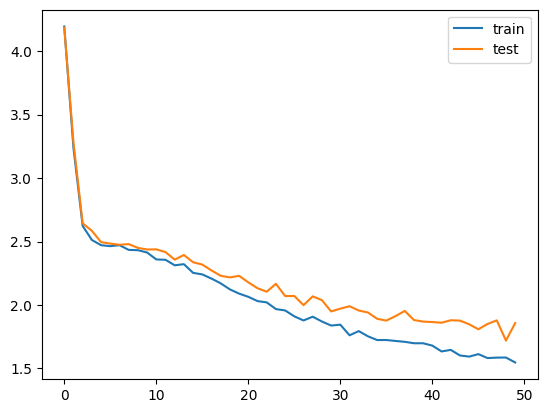

In [6]:
config = GPTConfig(n_embed=256, n_layers=6, n_heads=8, block_size=256, batch_size=64)
print(config)
model = GPT(config)
model.to(DEVICE)

train_steps = 1000

dataset = CharacterDataset.from_textfile('./input.txt', block_size=config.block_size)
train_dataset,test_dataset = dataset.train_test_split()

train_dataloader = DataLoader(
    dataset=train_dataset,
    sampler=RandomSampler(train_dataset, replacement=True, num_samples=train_steps * config.batch_size),
    pin_memory=True, # speed up transfer from CPU to GPU
    batch_size=config.batch_size,
)
test_dataloader = DataLoader(
    dataset=test_dataset,
    sampler=RandomSampler(test_dataset, replacement=True, num_samples=20),
    pin_memory=True, # speed up transfer from CPU to GPU
    batch_size=config.batch_size,
)

optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-3, betas=(0.9, 0.95))
model.train()

train_losses = []
test_losses = []

for i,(x,y) in enumerate(tqdm(train_dataloader)):
    x,y = x.to(DEVICE), y.to(DEVICE)
    # forward the model
    _,loss = model(x,y)
    if i % 20 == 0:
        train_losses.append(loss.item())
        test_loss = torch.tensor([model(test_x.to(DEVICE),test_y.to(DEVICE))[1] for test_x, test_y in test_dataloader])
        test_losses.append(torch.mean(test_loss).item())

    # backprop and update the parameters
    model.zero_grad(set_to_none=True)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()

plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.legend()

## Evaluate
We let the trained model generate a piece of text that should somewhat resemble shakespeare. Compare to what was generated from the untrained model.

In [7]:
model.eval()
model.generate()

  0%|          | 0/256 [00:00<?, ?it/s]

['\nMurder:\nThen, I take to make, and they shall now,\nIf thee would to thine.\n\nLADY CAPULET:\nI wourd me, being to be me shall been of yourself,\nWithout shall be to to my soul as bear than hear\nTimestion make or any to them passting thee,\nAnd shall a should and']